# Intuition for Overfitting

## Background

I was working on a classification project and getting great test results. But as you can imagine (since I'm writing this article), the results were too good to be true. I was overfitting my data. I want to share the intuition behind overfitting and how to avoid it with this toy example.

## The task

I have a dataset of ~200 emails, and I want to predict whether they are spam or not. 

In [53]:
import pandas as pd

df = pd.read_csv('./spam_ham_dataset.csv')
df.head()
print(df.shape)

(5171, 4)


Here's a spam email, and here's a real email.

In [23]:
# spam
print(df[df['label_num'] == 1]['text'].values[0])

Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin



In [25]:
# not spam
print(df[df['label_num'] == 0]['text'].values[0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


Let's clean up the text and lemmatize it.

In [42]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

df['clean_text'] = df['text'].apply(clean)

[nltk_data] Downloading package punkt to /Users/bkitano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bkitano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bkitano/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load the tf-idf vectorizer

We need to turn the emails into vectors of numbers. We'll use the tf-idf vectorizer from scikit-learn. 

Train and fit tf-idf on the dataset to create embeddings

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clean_text'].apply(lambda x: ' '.join(x)))
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y)

Fit logistic regression to classify based on lemmatized words, show that it works well

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))

print(cross_val_score(lr, X_train, y_train, cv=5))

print(classification_report(lr.predict(X_test), y_test))

0.9956162970603404
[0.98582474 0.98969072 0.98195876 0.98193548 0.98064516]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       934
           1       0.99      0.95      0.97       359

    accuracy                           0.98      1293
   macro avg       0.99      0.97      0.98      1293
weighted avg       0.98      0.98      0.98      1293



It's doing very well on the test set.

Dive in on how: the logistic regression is learning - learning a score for each word.

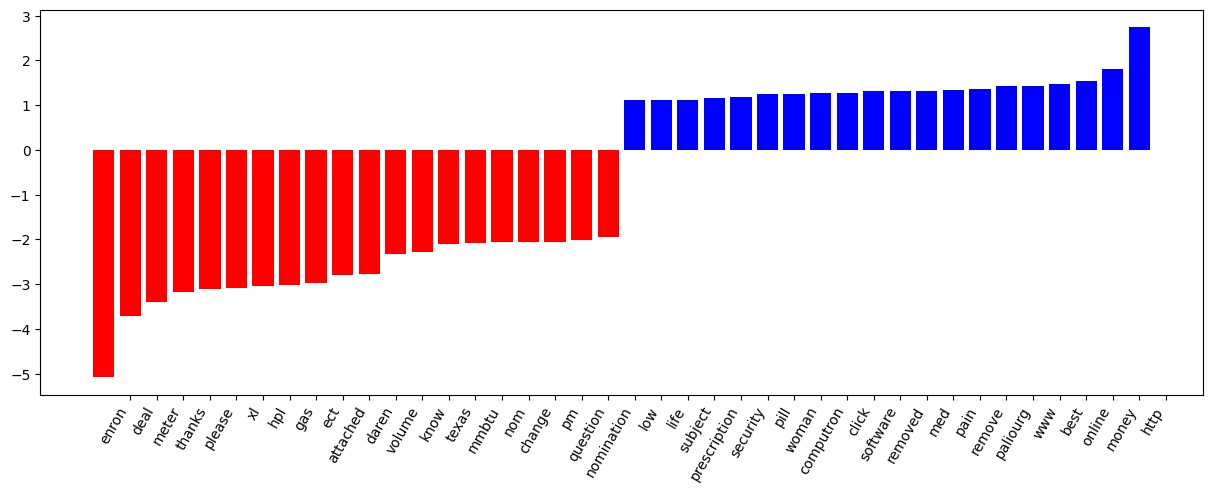

In [45]:
# get the weights of each word within the linear regression
import numpy as np
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]

    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

# get feature names from tfidf
feature_names = tfidf.get_feature_names_out()
plot_coefficients(lr, feature_names)


# How the neural net works

Load the SimpleNet, train it on the dataset, show that it works poorly

In [47]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# convert dataset to tensors
_X, _y = torch.Tensor(X.todense()), torch.Tensor(y)
X_train, X_test, y_train, y_test = train_test_split(_X, _y)

# Convert datasets to TensorDataset and use DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [48]:
from torch import nn
from torch.nn import functional as F

def get_layers_list(layer_sizes, dropout=.2):
    tups = zip(layer_sizes[:-1], layer_sizes[1:])
    modules = [nn.Linear(t[0], t[1]) for t in tups]
    dropouts = [nn.Dropout(dropout) for _ in range(len(modules))]
    layers = [i for t in zip(modules, dropouts) for i in t]
    return layers

class SimpleNet(nn.Module):
    def __init__(self, layers_list, dropout=.2):
        super().__init__()
        module_list = get_layers_list(layers_list, dropout)
        self.layers = nn.ModuleList(module_list)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        # if you relu before sigmoid on output, you'll never get values < 0, so you'll never get probs less than .5
        last = self.layers[-1](x) 
        
        out = F.sigmoid(last)
        return out
    
model = SimpleNet([X_train.shape[1], 1])

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch} loss: {loss.item()}')

Epoch 0 loss: 0.5815473198890686
Epoch 1 loss: 0.5846753716468811
Epoch 2 loss: 0.4117375612258911
Epoch 3 loss: 0.6057884097099304
Epoch 4 loss: 0.6025829911231995
Epoch 5 loss: 0.4955756664276123
Epoch 6 loss: 0.6931471824645996
Epoch 7 loss: 0.6931471824645996
Epoch 8 loss: 0.35805490612983704
Epoch 9 loss: 0.3578105866909027


In [55]:
def print_class_report(model, X_val, y_val):
    model.eval()
    y_pred = model(X_val)
    y_pred = y_pred.detach().numpy()
    y_pred = np.round(y_pred)
    y_pred = y_pred.squeeze()

    print(classification_report(y_val.squeeze().detach().numpy(), y_pred, zero_division=0, target_names=['automated', 'human'], labels=[0, 1]))

print_class_report(model, X_test, y_test)

              precision    recall  f1-score   support

   automated       1.00      0.81      0.90       925
       human       0.68      1.00      0.81       368

    accuracy                           0.87      1293
   macro avg       0.84      0.91      0.85      1293
weighted avg       0.91      0.87      0.87      1293



Show that the weight of each node is learning a score for each word.

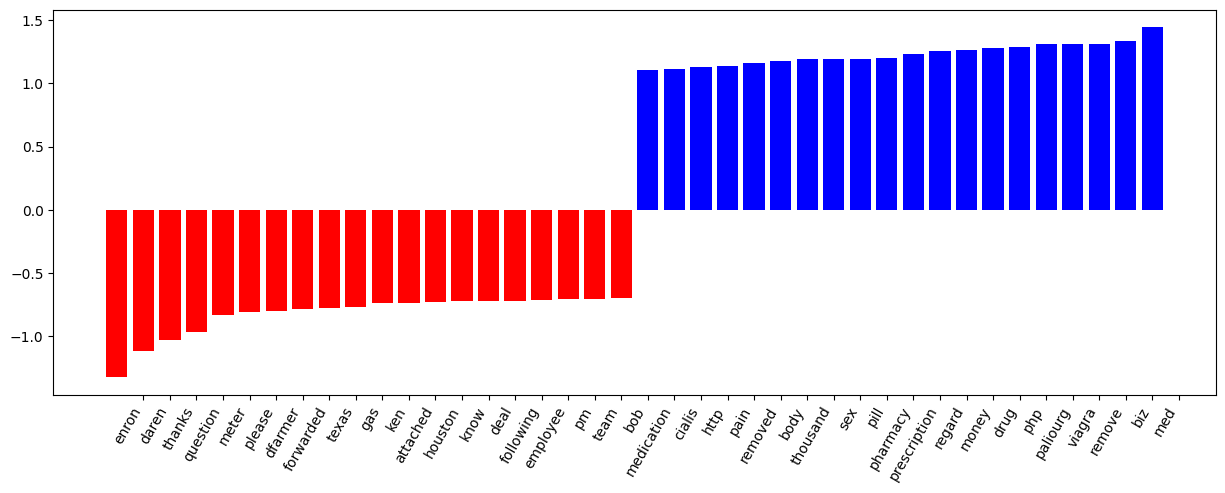

In [61]:
# get the weights of each word within the linear regression
word_to_idx = {word: idx for idx, word in enumerate(feature_names)}
weights = model.layers[0].weight.detach().numpy()

weights = weights.squeeze()
top_features = 20
top_positive_coefficients = np.argsort(weights)[-top_features:]
top_negative_coefficients = np.argsort(weights)[:top_features]

top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in weights[top_coefficients]]
plt.bar(np.arange(2 * top_features), weights[top_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
plt.show()

Show Spearman correlation between the logistic regression and the neural net.

In [63]:
# spearman correlation between neural net weights and logistic regression weights
from scipy.stats import spearmanr

lr_weights = lr.coef_.ravel()
nn_weights = weights

spearmanr(lr_weights, nn_weights)

SignificanceResult(statistic=0.6825588466413658, pvalue=0.0)

Show how the SimpleNet is actually an ensemble of independent logistic regressions, each learning a score for each word. The output node is yet another logistic regression, learning a score for each group of words.

Show that if we investigate a single first-layer neuron, we can actually map it to a single email in our dataset - indicating severe overfitting.

Explore whether adding regularization helps. It does, but not enough.
- dropout
- `l2` regularization

Conclusions: neural nets are not magic, they are just a bunch of logistic regressions. They are not a good fit for this problem, because they are too powerful and overfit.